tb - 10/18/2021 - Reproduce results from Ryan and output (1) number of free parameters ; and (2) mean error statistics of the net shortwave flux prediction (in $W m^{-2} $) from best-performing model.

Kind instruction email from Ryan L below:

•	The Python library, called ml4rt, is available here.  It's under the MIT licence, so feel free to use/modify for any non-commercial purposes.
•	To read the files with learning examples (all NetCDF files in the directories tropical_sites and non_tropical_sites), use example_io.read_file, which you can find here.  I recommend always using the options exclude_summit_greenland = True (the RRTM, which is the model we're trying to emulate, made some errors on these profiles, so the labels are inaccurate) and max_heating_rate_k_day = numpy.inf (in other words, don't filter by heating rate).  example_io.read_file returns a dictionary, and the format of this dictionary is documented in the method string for example_io.read_file.
•	One file (non_tropical_sites/learning_examples_20170101-20181224.nc) contains normalization parameters, used to normalize data before input to the neural net.
•	To normalize data, use the method normalization.normalize_data (here), where new_example_dict contains the examples you want to normalize and training_example_dict contains normalization parameters (read from non_tropical_sites/learning_examples_20170101-20181224.nc).  For some example usage of normalization.normalize_data, see neural_net.read_file_for_generator (here), where the method is called 3 times.
•	To read the model (a U-net++), use the method neural_net.read_model (here).  Make sure the metafile (model_metadata.dill) is always in the same directory as the actual model (model.h5).
•	To read the data and prepare it for input to the the neural net (i.e., pre-process it the same way the training data was pre-processed), use neural_net.create_data (here) or neural_net.data_generator (here).
•	To apply the trained neural net to some data, use neural_net.create_data or neural_net.data_generator to read/pre-process the data, then use neural_net.apply_model (here) with net_type_string = "u_net".  I recommend verbose = True and num_examples_per_batch = 5000 (but you may need it smaller if you have a computer with limited RAM).  predictor_matrix will be the predictor_matrix returned by neural_net.create_data or neural_net.data_generator.

I hope this is enough to get you started.  Please let me know if you have any questions about the code.  It's a bit complicated because [a] the neural net has both scalar and vector inputs (the scalars being solar zenith angle and surface albedo, the vectors being 1-D profiles of other variables); [b] the neural net has both scalar and vector outputs (the scalars being TOA upwelling flux, sfc downwelling flux, and net flux; the vector being a 1-D profile of heating rates; other possible vector outputs are full profiles of upwelling and downwelling flux, but I've since stopped predicting these, since NWP models don't require them from a paramzn).

# Imports

In [1]:
from ml4rt.io.example_io import *
from ml4rt.utils.normalization import *
from ml4rt.machine_learning.neural_net import *
from ml4rt.machine_learning.u_net_architecture import *
from ml4rt.machine_learning.u_net_pp_architecture import *

import dill

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
fz = 15
lw = 4
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

# Read Files

In [3]:
read_file

<function ml4rt.io.example_io.read_file(netcdf_file_name, exclude_summit_greenland=False, max_heating_rate_k_day=41.5, id_strings_to_read=None, allow_missing_ids=False)>

In [4]:
path_data = '/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/'

## Read 2020

In [5]:
read2020 = read_file(path_data+'tropical_sites/learning_examples_2020.nc',
                     exclude_summit_greenland=True)

/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/ml4rt/notebooks_tbeucler/ml4rt/io/example_io.py:304: UserWarning: Removing 0 of 264638 examples (profiles), because they are at Summit GL.
  warnings.warn(warning_string)


In [6]:
read2020.keys()

dict_keys(['example_id_strings', 'scalar_predictor_names', 'vector_predictor_names', 'scalar_target_names', 'vector_target_names', 'scalar_predictor_matrix', 'vector_predictor_matrix', 'scalar_target_matrix', 'vector_target_matrix', 'valid_times_unix_sec', 'standard_atmo_flags', 'heights_m_agl'])

In [7]:
read2020['scalar_predictor_matrix'].shape

(264638, 6)

In [8]:
read2020['scalar_predictor_names']

['zenith_angle_radians',
 'albedo',
 'latitude_deg_n',
 'longitude_deg_e',
 'column_liquid_water_path_kg_m02',
 'column_ice_water_path_kg_m02']

In [9]:
read2020['vector_predictor_matrix'].shape

(264638, 73, 12)

In [10]:
read2020['vector_predictor_names']

['pressure_pascals',
 'temperature_kelvins',
 'specific_humidity_kg_kg01',
 'liquid_water_content_kg_m03',
 'ice_water_content_kg_m03',
 'liquid_water_path_kg_m02',
 'ice_water_path_kg_m02',
 'vapour_path_kg_m02',
 'upward_liquid_water_path_kg_m02',
 'upward_ice_water_path_kg_m02',
 'upward_vapour_path_kg_m02',
 'relative_humidity_unitless']

In [11]:
read2020['scalar_target_names']

['shortwave_surface_down_flux_w_m02', 'shortwave_toa_up_flux_w_m02']

In [12]:
read2020['scalar_target_matrix'].shape

(264638, 2)

In [13]:
read2020['vector_target_names']

['shortwave_down_flux_w_m02',
 'shortwave_up_flux_w_m02',
 'shortwave_heating_rate_k_day01',
 'shortwave_down_flux_increment_w_m03',
 'shortwave_up_flux_increment_w_m03']

In [14]:
read2020['vector_target_matrix'].shape

(264638, 73, 5)

## Read 2018

In [38]:
read2018_nt = read_file(path_data+'non_tropical_sites/learning_examples_2018.nc',
                     exclude_summit_greenland=True)

In [39]:
read2018_nt['vector_predictor_matrix'].shape

(897508, 73, 12)

## Read non tropical 2019/2020 and tropical 2017

In [5]:
read2019_nt = read_file(path_data+'non_tropical_sites/learning_examples_2019.nc',
                     exclude_summit_greenland=True)

/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/ml4rt/notebooks_tbeucler/ml4rt/io/example_io.py:304: UserWarning: Removing 0 of 964823 examples (profiles), because they are at Summit GL.
  warnings.warn(warning_string)


In [6]:
read2020_nt = read_file(path_data+'non_tropical_sites/learning_examples_2020.nc',
                     exclude_summit_greenland=True)

/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/ml4rt/notebooks_tbeucler/ml4rt/io/example_io.py:304: UserWarning: Removing 0 of 534274 examples (profiles), because they are at Summit GL.
  warnings.warn(warning_string)


In [7]:
read2017_t = read_file(path_data+'tropical_sites/learning_examples_2017.nc',
                     exclude_summit_greenland=True)

/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/ml4rt/notebooks_tbeucler/ml4rt/io/example_io.py:304: UserWarning: Removing 0 of 260300 examples (profiles), because they are at Summit GL.
  warnings.warn(warning_string)


# Normalize data (Unused at this point)

## Load normalization parameters from non tropical sites

In [8]:
path_norm_param = path_data+'non_tropical_sites/learning_examples_20170101-20181224.nc'

In [9]:
norm_param = read_file(path_norm_param,
                     exclude_summit_greenland=True,
                     max_heating_rate_k_day)

SyntaxError: positional argument follows keyword argument (927265104.py, line 3)

In [ ]:
norm_param.keys()

## Apply normalization 
Following [https://github.com/thunderhoser/ml4rt/blob/8ad36b52ead1c4870bdccaa804dee9a52144cce0/ml4rt/machine_learning/neural_net.py#L213]

In [ ]:
normalize_data

The normalization is automatically applied as part of data_generator (see _read_file_for_generator)

In [21]:
data_generator

<function ml4rt.machine_learning.neural_net.data_generator(option_dict, for_inference, net_type_string)>

# Read UNet++ trained by Ryan

In [10]:
read_model

<function ml4rt.machine_learning.neural_net.read_model(hdf5_file_name)>

In [8]:
path_model = path_data + 'actual_model/model.h5'

In [9]:
Unetpp = read_model(path_model)

/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/miniconda3/envs/ml4rt/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1030: UserWarning: u_net_architecture is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)
2022-06-14 21:34:00.931040: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-06-14 21:34:01.349060: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2894740000 Hz
2022-06-14 21:34:01.350923: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f704ec6110 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-14 21:34:01.350954: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-14 21:34:01.391837: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with def

In [10]:
Unetpp.summary()

Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 73, 14)]     0                                            
__________________________________________________________________________________________________
block0-0_conv0 (Conv1D)         (None, 73, 64)       2752        input_65[0][0]                   
__________________________________________________________________________________________________
block0-0_conv0_activation (Leak (None, 73, 64)       0           block0-0_conv0[0][0]             
__________________________________________________________________________________________________
block0-0_conv0_bn (BatchNormali (None, 73, 64)       256         block0-0_conv0_activation[0][0]  
___________________________________________________________________________________________

In [9]:
Unetpp_total_p = 14952344
Unetpp_train_p = 14937052

# Test UNet++ trained by Ryan

## On shortwave heating rates and top/bottom fluxes

In [10]:
data_generator

<function ml4rt.machine_learning.neural_net.data_generator(option_dict, for_inference, net_type_string)>

### Loading model's metadata using dill

In [11]:
model_arc = dill.load(open(path_data+'actual_model/model_metadata.dill','rb'))

In [12]:
model_arc.keys()

dict_keys(['num_epochs', 'num_training_batches_per_epoch', 'training_option_dict', 'num_validation_batches_per_epoch', 'validation_option_dict', 'net_type_string', 'loss_function_or_dict', 'do_early_stopping', 'plateau_lr_multiplier'])

In [13]:
model_arc['net_type_string']

'u_net'

In [14]:
model_arc['validation_option_dict']

{'scalar_predictor_names': ['zenith_angle_radians', 'albedo'],
 'vector_predictor_names': ['pressure_pascals',
  'temperature_kelvins',
  'specific_humidity_kg_kg01',
  'liquid_water_content_kg_m03',
  'ice_water_content_kg_m03',
  'relative_humidity_unitless',
  'liquid_water_path_kg_m02',
  'ice_water_path_kg_m02',
  'vapour_path_kg_m02',
  'upward_liquid_water_path_kg_m02',
  'upward_ice_water_path_kg_m02',
  'upward_vapour_path_kg_m02'],
 'scalar_target_names': ['shortwave_surface_down_flux_w_m02',
  'shortwave_toa_up_flux_w_m02'],
 'vector_target_names': ['shortwave_heating_rate_k_day01'],
 'heights_m_agl': array([1.00e+01, 2.00e+01, 4.00e+01, 6.00e+01, 8.00e+01, 1.00e+02,
        1.20e+02, 1.40e+02, 1.60e+02, 1.80e+02, 2.00e+02, 2.25e+02,
        2.50e+02, 2.75e+02, 3.00e+02, 3.50e+02, 4.00e+02, 4.50e+02,
        5.00e+02, 6.00e+02, 7.00e+02, 8.00e+02, 9.00e+02, 1.00e+03,
        1.10e+03, 1.20e+03, 1.30e+03, 1.40e+03, 1.50e+03, 1.60e+03,
        1.70e+03, 1.80e+03, 1.90e+03, 2.0

In [15]:
model_arc['validation_option_dict']['example_dir_name'] = \
'/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites'

In [16]:
model_arc['validation_option_dict']['normalization_file_name'] = model_arc['validation_option_dict']['example_dir_name'] + \
'/learning_examples_20170101-20181224.nc'

In [17]:
# model_arc['validation_option_dict']['first_time_unix_sec'] = 1514764800 # Jan 1, 2018 at 12:00:00AM
# model_arc['validation_option_dict']['last_time_unix_sec'] = 1546300799 # Dec 31, 2018 at 11:59:59PM

In [18]:
model_arc['validation_option_dict']['first_time_unix_sec'] = 1546326000 # Jan 1, 2019 at 12:00:00AM
model_arc['validation_option_dict']['last_time_unix_sec'] = 1577861999 # Dec 31, 2019 at 11:59:59PM

In [19]:
#Unetpp_gen = data_generator(model_arc['validation_option_dict'],True,model_arc['net_type_string'])

In [20]:
Unetpp_2019 = create_data(model_arc['validation_option_dict'],True, 
                          model_arc['net_type_string'],exclude_summit_greenland=True)

Reading training examples (for normalization) from: "/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/learning_examples_20170101-20181224.nc"...

Reading data from: "/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/learning_examples_2019.nc"...
Applying Z_SCORE normalization to predictors...
Applying MINMAX normalization to scalar targets...

Reading data from: "/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/learning_examples_2020.nc"...
Applying Z_SCORE normalization to predictors...
Applying MINMAX normalization to scalar targets...


In [21]:
model_arc['validation_option_dict']['first_time_unix_sec'] = 1577862000 # Jan 1, 2020 at 12:00:00AM
model_arc['validation_option_dict']['last_time_unix_sec'] = 1609484399 # Dec 31, 2020 at 11:59:59PM

In [22]:
Unetpp_2020 = create_data(model_arc['validation_option_dict'],True, 
                          model_arc['net_type_string'],exclude_summit_greenland=True)

Reading training examples (for normalization) from: "/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/learning_examples_20170101-20181224.nc"...

Reading data from: "/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/learning_examples_2020.nc"...
Applying Z_SCORE normalization to predictors...
Applying MINMAX normalization to scalar targets...


In [23]:
model_arc['validation_option_dict']['first_time_unix_sec'] = 1483254000 # Jan 1, 2017 at 12:00:00AM
model_arc['validation_option_dict']['last_time_unix_sec'] = 1514789999 # Dec 31, 2017 at 11:59:59PM

In [24]:
model_arc['validation_option_dict']['example_dir_name'] = \
'/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/tropical_sites'

In [25]:
Unetpp_2017_trop = create_data(model_arc['validation_option_dict'],True, 
                               model_arc['net_type_string'],exclude_summit_greenland=True)

Reading training examples (for normalization) from: "/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/learning_examples_20170101-20181224.nc"...

Reading data from: "/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/tropical_sites/learning_examples_2017.nc"...
Applying Z_SCORE normalization to predictors...
Applying MINMAX normalization to scalar targets...

Reading data from: "/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/tropical_sites/learning_examples_2018.nc"...


/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/ml4rt/notebooks_tbeucler/ml4rt/io/example_io.py:304: UserWarning: Removing 0 of 303637 examples (profiles), because they are at Summit GL.
  warnings.warn(warning_string)


Applying Z_SCORE normalization to predictors...
Applying MINMAX normalization to scalar targets...


In [27]:
Unetpp_2020[0].shape

(533669, 73, 14)

In [29]:
Unetpp_2017_trop[0].shape

(255811, 73, 14)

### Make predictions

In [30]:
apply_model

<function ml4rt.machine_learning.neural_net.apply_model(model_object, predictor_matrix, num_examples_per_batch, net_type_string, verbose=False)>

In [64]:
ibeg = 0
iend = 200000

In [65]:
Apply2019 = apply_model(Unetpp, Unetpp_2019[0][ibeg:iend,:,:],1000,model_arc['net_type_string'])

In [66]:
Apply2020 = apply_model(Unetpp, Unetpp_2020[0][ibeg:iend,:,:],1000,model_arc['net_type_string'])

In [67]:
Apply2017 = apply_model(Unetpp, Unetpp_2017_trop[0][ibeg:iend,:,:],1000,model_arc['net_type_string'])

In [26]:
Unetpp_apply[1].shape

(50000, 2)

In [27]:
Unetpp_apply[0].shape

(50000, 73, 1)

In [28]:
#Unet_predictors = denormalize_data(Unetpp_data,model_arc['validation_option_dict'],'z_score')

In [29]:
Pred_Q = Unetpp_apply[0][:,:,0]

In [30]:
Pred_Q.shape

(50000, 73)

In [68]:
Pred_Q_2019 = Apply2019[0][:,:,0]
Pred_Q_2020 = Apply2020[0][:,:,0]
Pred_Q_2017 = Apply2017[0][:,:,0]

### Convert to net fluxes; first try on truth

In [69]:
def Fnet_from_Q(p,Q,Fnet_TOA):
    
    GRAVITY_CONSTANT_M_S02 = 9.8066
    DRY_AIR_SPECIFIC_HEAT_J_KG01_K01 = 1004.
    
    FfromQ = np.zeros_like(p)
    print('Calculating vertical pressure increments')
    dp = p[:,:-1]-p[:,1:]
    for iz in range(Q.shape[1]):
        print('iz=',iz,'/',str(Q.shape[1]-1),'                     ',end='\r')
        FfromQ[:,iz] = Fnet_TOA-DRY_AIR_SPECIFIC_HEAT_J_KG01_K01/GRAVITY_CONSTANT_M_S02*\
        np.sum(dp[:,iz:]*Q[:,iz:-1]/(24*3600),axis=1)
    
    FfromQ[:,-1] = Fnet_TOA
    
    return FfromQ

In [70]:
p2019 = read2019_nt['vector_predictor_matrix'][:,:,0]
p2020 = read2020_nt['vector_predictor_matrix'][:,:,0]
p2017 = read2017_t['vector_predictor_matrix'][:,:,0]

In [71]:
pread.shape

(964044, 73)

In [72]:
pmean = np.mean(pread[ibeg:iend,:],axis=0)

In [73]:
#Qtruth = read2018_nt['vector_target_matrix'][:,:,2]
Qtruth2019 = read2019_nt['vector_target_matrix'][:,:,2]
Qtruth2020 = read2020_nt['vector_target_matrix'][:,:,2]
Qtruth2017 = read2017_t['vector_target_matrix'][:,:,2]

In [74]:
Qmean = np.mean(Qtruth[ibeg:iend,:],axis=0)

NameError: name 'Qtruth' is not defined

In [75]:
#Fnet_truth = read2018_nt['vector_target_matrix'][:,:,0]-read2018_nt['vector_target_matrix'][:,:,1]
Fnet_truth2019 = read2019_nt['vector_target_matrix'][:,:,0]-read2019_nt['vector_target_matrix'][:,:,1]
Fnet_truth2020 = read2020_nt['vector_target_matrix'][:,:,0]-read2020_nt['vector_target_matrix'][:,:,1]
Fnet_truth2017 = read2017_t['vector_target_matrix'][:,:,0]-read2017_t['vector_target_matrix'][:,:,1]

In [ ]:
Fnet_mean = np.mean(Fnet_truth[ibeg:iend,:],axis=0)

Qtruth to Fnet

In [47]:
FfromQ = Fnet_from_Q(pread,Qtruth,Fnet_truth[:,-1])

Calculating vertical pressure increments


In [48]:
FfromQ_mean = np.mean(FfromQ[ibeg:iend,:],axis=0)

In [50]:
Pred_Q_mean = np.mean(Pred_Q,axis=0)

In [51]:
Pred_Fnet = Fnet_from_Q(pread[ibeg:iend,:],Pred_Q,Fnet_truth[ibeg:iend,-1])

Calculating vertical pressure increments


In [52]:
Pred_Fnet_mean = np.mean(Pred_Fnet,axis=0)

In [76]:
F_truth2019 = Fnet_from_Q(p2019,Qtruth2019,Fnet_truth2019[:,-1])
F_truth2020 = Fnet_from_Q(p2020,Qtruth2020,Fnet_truth2020[:,-1])
F_truth2017 = Fnet_from_Q(p2017,Qtruth2017,Fnet_truth2017[:,-1])

Calculating vertical pressure increments
Calculating vertical pressure increments
Calculating vertical pressure increments


In [77]:
F_pred2019 = Fnet_from_Q(p2019[ibeg:iend,:],Pred_Q_2019,Fnet_truth2019[ibeg:iend,-1])
F_pred2020 = Fnet_from_Q(p2020[ibeg:iend,:],Pred_Q_2020,Fnet_truth2020[ibeg:iend,-1])
F_pred2017 = Fnet_from_Q(p2017[ibeg:iend,:],Pred_Q_2017,Fnet_truth2017[ibeg:iend,-1])

Calculating vertical pressure increments
Calculating vertical pressure increments
Calculating vertical pressure increments


### Summary figure

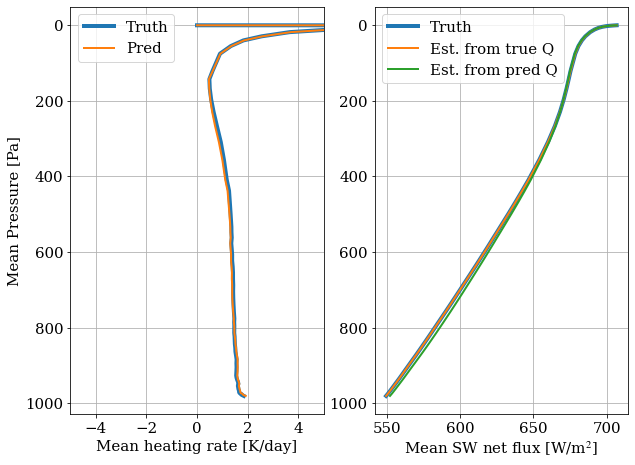

In [53]:
fig,ax = plt.subplots(1,2,figsize=(10,7.5))

ax[0].plot(Qmean,pmean/1e2,label='Truth')
ax[0].plot(Pred_Q_mean,pmean/1e2,label='Pred',linewidth=0.5*lw)
ax[0].invert_yaxis()
ax[0].set_xlabel('Mean heating rate [K/day]')
ax[0].set_ylabel('Mean Pressure [Pa]')
ax[0].grid()
ax[0].legend()
ax[0].set_xlim((-5,5))

ax[1].plot(Fnet_mean,pmean/1e2,label='Truth')
ax[1].plot(FfromQ_mean,pmean/1e2,label='Est. from true Q',linewidth=0.5*lw)
ax[1].plot(Pred_Fnet_mean,pmean/1e2,label='Est. from pred Q',linewidth=0.5*lw)
ax[1].invert_yaxis()
ax[1].set_xlabel('Mean SW net flux [W/m$^{2}$]')
ax[1].grid()
ax[1].legend()
#ax[1].set_xlim((-5,5))

In [54]:
MSE_Ryan_L = np.mean((FfromQ[ibeg:iend,:]-Pred_Fnet)**2)

In [55]:
MSE_Ryan_L

13.04298392884858

In [56]:
FfromQ.shape

(897508, 73)

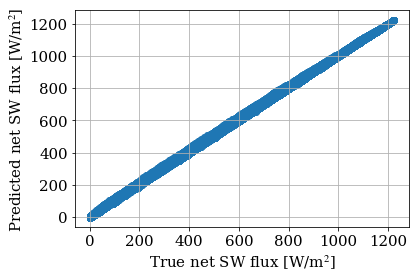

In [57]:
plt.scatter(FfromQ[ibeg:iend,:].flatten(),Pred_Fnet.flatten())
plt.xlabel('True net SW flux [W/m${^2}$]')
plt.ylabel('Predicted net SW flux [W/m${^2}$]')
plt.grid()

### Error statistics

In [58]:
# From https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-np
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- np ndarrays with the same shape.
    """
    if np.sum(weights)>0:
        average = np.average(values, weights=weights)
        variance = np.average((values-average)**2, weights=weights)
    else:
        average = np.nan
        variance = np.nan
    return (average, np.sqrt(variance))

# Make function to calculate conditional mean and std
# We condition field_y on field_x
def conditional_avg_and_std(bin_edges,field_x,field_y):
    # Initialization
    Nbin = np.size(bin_edges)
    Ym = np.zeros((Nbin-1,1))
    Ystd = np.copy(Ym)

    for ibin,edge in enumerate(bin_edges):
        print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
        if ibin>0:
            w = (field_x>=edge_left)*(field_x<edge)
            Ym[ibin-1],Ystd[ibin-1] = weighted_avg_and_std(field_y,w)

        edge_left = edge
    
    return Ym,Ystd

In [82]:
mse = np.mean((FfromQ[ibeg:iend,:]-Pred_Fnet)**2,axis=1)

In [83]:
mse.shape

(50000,)

In [84]:
his_mse = np.histogram(mse,bins=100);

In [60]:
Unetpp_apply[0].shape

(50000, 73, 1)

In [61]:
Unetpp_apply[1].shape

(50000, 2)

In [64]:
Unetpp_data[0][ibeg:iend,:,:].shape

(50000, 73, 14)

In [72]:
Unetpp_data[1][0].shape

(897508, 73, 1)

In [73]:
Unetpp_data[1][1].shape

(897508, 2)

In [88]:
zenith_av = conditional_avg_and_std(his_mse[1],mse,Unetpp_data[1][1][ibeg:iend,0])

In [90]:
# From edges to middle of bins
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

Text(0.5, 1.0, 'Conditional average')

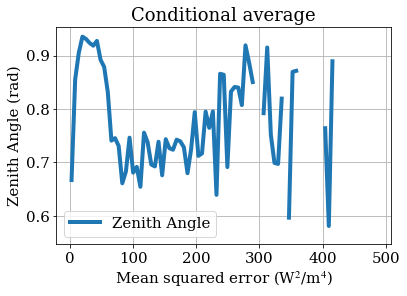

In [91]:
plt.plot(edgTObin(his_mse[1]),zenith_av[0],label='Zenith Angle')
plt.grid()
plt.legend()
plt.xlabel('Mean squared error (W$^{2}$/m$^{4}$)')
plt.ylabel('Zenith Angle (rad)')
plt.title('Conditional average')

## Error statistics for AOFD

MSE on training set

In [104]:
mse2019 = np.mean((F_truth2019[ibeg:iend,:]-F_pred2019)**2)
mse2020 = np.mean((F_truth2020[ibeg:iend,:]-F_pred2020)**2)
med2019 = np.median((F_truth2019[ibeg:iend,:]-F_pred2019)**2)
med2020 = np.median((F_truth2020[ibeg:iend,:]-F_pred2020)**2)

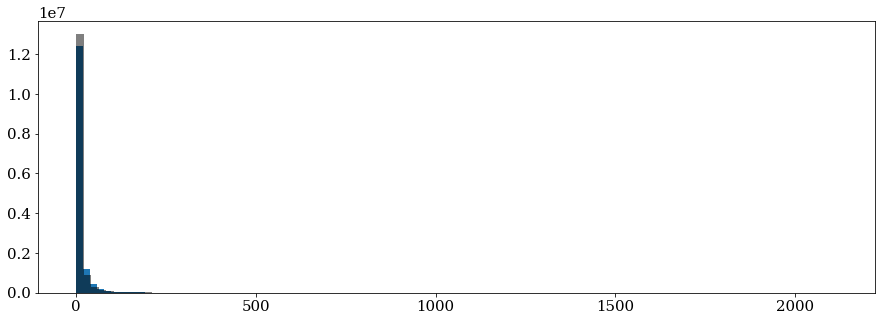

In [93]:
plt.figure(figsize=(15,5))
plt.hist(((F_truth2019[ibeg:iend,:]-F_pred2019)**2).flatten(),bins=100);
plt.hist(((F_truth2020[ibeg:iend,:]-F_pred2020)**2).flatten(),bins=100,color='k',alpha=0.5);


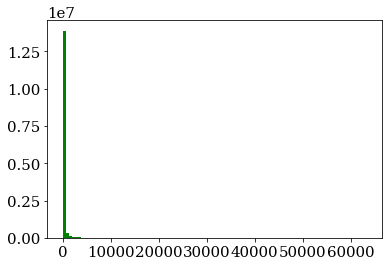

In [95]:
plt.hist(((F_truth2017[ibeg:iend,:]-F_pred2017)**2).flatten(),bins=100,color='g');

In [79]:
mse2019

10.785831089622942

In [80]:
mse2020

9.688152436192357

In [96]:
mse201920 = (mse2019+mse2020)/2

In [97]:
mse201920

10.23699176290765

In [105]:
med2019

1.540658077043159

In [106]:
med2020

1.0625989083760838

In [113]:
np.percentile((F_truth2019[ibeg:iend,:]-F_pred2019)**2,70)

6.7253532378988

MSE on test set

In [107]:
mse2017 = np.mean((F_truth2017[ibeg:iend,:]-F_pred2017)**2)
med2017 = np.median((F_truth2017[ibeg:iend,:]-F_pred2017)**2)

In [108]:
mse2017

159.293249502594

In [109]:
med2017

6.974405756419175

In [111]:
np.percentile((F_truth2017[ibeg:iend,:]-F_pred2017)**2,80)

76.76443905153631

Distributions of errors very right-skewed; For the training set, the mean is between the 70th and 80th percentiles while it's between the 80th and the 90th over the training set. In both cases, the median is less than 10 times the mean, which could be due to a lot of night samples.